# Merges simulations, checking the oldest files in the directories. Some simulations were extended and appending was not possible, so the names got messy.
# The following code is not elegant but parts might be reused later.

# Libraries

In [4]:
import os
import MDAnalysis as mda
import pandas as pd


# Functions

In [66]:
def gmx_check(file_path):
    """
    Check the GROMACS trajectory file for errors.
    
    Parameters:
    file_path (str): Path to the GROMACS trajectory file.
    
    Returns:
    str: Output of the gmx check command.
    """
    gmx = "/usr/local/gromacs-2024.4/bin/gmx"
    command = f"{gmx} check -f {file_path}"
    #Read stderr
    result = os.popen(command + " 2>&1").read()
    #Get the value after "Step"
    if "Step" in result:
        step_value = result.split("Step")[1].split()[0]
        print(f"Step value: {step_value}")
    else:
       step_value = None
    return step_value

def gmx_check_parallel(file_paths, n_jobs=10):
    """
    Check multiple GROMACS trajectory files in parallel.
    
    Parameters:
    file_paths (list): List of paths to the GROMACS trajectory files.
    n_jobs (int): Number of parallel jobs to run.
    
    Returns:
    list: List of results from gmx check for each file.
    """
    from joblib import Parallel, delayed
    results = Parallel(n_jobs=n_jobs)(delayed(gmx_check)(file) for file in file_paths)
    return results

def gmx_concatenate(file_paths, output_file):
    """
    Concatenate multiple GROMACS trajectory files into one.
    
    Parameters:
    file_paths (list): List of paths to the GROMACS trajectory files.
    output_file (str): Path to the output concatenated file.
    """
    gmx = "/usr/local/gromacs-2024.4/bin/gmx"
    n_files = len(file_paths)
    # Repeat c/\n for the number of files
    c_lines = 'c\\n' * n_files
    basedir = os.path.dirname(file_paths[0])
    command = f"echo -e '{c_lines}' | {gmx} trjcat -f {' '.join(file_paths)} -o {basedir}/{output_file}"
    #print(f"Running command: {command}")
    #os.system(command)
    return command





# Analyzing raw results

In [2]:
chains = ["4", "r", "s", "c"]
seeds = ["242", "484"]
rotations = 20

dict_directories = {}

for chain in chains:
    for seed in seeds:
        for rotation in range(1, rotations + 1):
            dir = f"/martini/rubiz/interaction_partner_paper/4_pairs/chain_{chain}/seed{seed}/chain_{chain}/initial-{rotation:04d}"
            dict_directories[f"{chain}-{seed}-{rotation}"] = dir

            


In [4]:
array_of_arrays = []

for key, dir_path in dict_directories.items():
    try:
        # Check if directory exists first
        if not os.path.exists(dir_path):
            print(f"{key}: Directory does not exist")
            array_of_arrays.append([])
            continue
            
        files = os.listdir(dir_path)
        xtc_files = [f for f in files if f.endswith('.xtc')]
            
        # Sort files by modification time (similar to ls -rtl)
        xtc_files_with_path = []
        for f in xtc_files:
            full_path = os.path.join(dir_path, f)
            if os.path.isfile(full_path):  # Make sure it's actually a file
                try:
                    mtime = os.path.getmtime(full_path)
                    xtc_files_with_path.append((f, mtime))
                except Exception as file_err:
                    print(f"{key}: Error getting mtime for {f}: {file_err}")
                    
        xtc_files_sorted = [f[0] for f in sorted(xtc_files_with_path, key=lambda x: x[1])]
        array_of_arrays.append(xtc_files_sorted)
            
    except Exception as e:
        print(f"{key}: Error - {e}")
        array_of_arrays.append([])

print(f"\nTotal directories processed: {len(array_of_arrays)}")
print(f"Successfully processed XTC files from {len([x for x in array_of_arrays if x])} directories")


Total directories processed: 160
Successfully processed XTC files from 160 directories


In [18]:
#Filter the arrays afer the file 3-run3.xtc
filtered_array_of_arrays = []
file="proteins_2000ns.xtc"
for arr in array_of_arrays:
    index = arr.index(file)
    del_before = len(arr) - index 
    filtered_array = arr[-del_before+1:]
    filtered_array_of_arrays.append(filtered_array)


In [19]:
print(filtered_array_of_arrays)

[['3-run2.part0002.xtc', 'last.part0002.xtc', 'last.part0003.xtc'], ['3-run2.part0002.xtc', 'last.part0002.xtc'], ['3-run2.part0002.xtc', 'last.part0002.xtc'], ['3-run2.part0002.xtc', 'last.part0002.xtc'], ['3-run2.part0002.xtc', 'last.part0002.xtc'], ['3-run2.part0002.xtc', 'last.part0002.xtc'], ['3-run2.part0002.xtc', 'last.part0002.xtc'], ['3-run2.part0002.xtc', 'last.part0002.xtc'], ['3-run2.part0002.xtc', 'last.part0002.xtc'], ['3-run2.part0002.xtc', 'last.part0002.xtc'], ['3-run2.part0002.xtc', 'last.part0002.xtc'], ['3-run2.part0002.xtc', 'last.part0002.xtc'], ['3-run2.part0002.xtc', 'last.part0002.xtc'], ['3-run2.part0002.xtc', 'last.part0002.xtc'], ['3-run2.part0002.xtc', 'last.part0002.xtc'], ['3-run2.part0002.xtc', 'last.part0002.xtc'], ['3-run2.part0002.xtc', 'last.part0002.xtc'], ['3-run2.part0002.xtc', 'last.part0002.xtc'], ['3-run2.part0002.xtc', 'last.part0002.xtc'], ['3-run2.part0002.xtc', 'last.part0002.xtc'], ['3-run2.part0002.xtc', 'last.part0002.xtc'], ['3-run2.par

In [22]:
# Create data for the dataframe with trajectory columns
data = []
for i, (key, directory) in enumerate(dict_directories.items()):    
    files_list = filtered_array_of_arrays[i] if i < len(filtered_array_of_arrays) else []
    
    row = {
        'directory': directory,
        'num_files': len(files_list)
    }

    # Add trajectory columns with full paths (directory + filename)
    max_trajectories = max(len(arr) for arr in filtered_array_of_arrays) if filtered_array_of_arrays else 0
    for j in range(max_trajectories):
        col_name = f'trajectory{j+1}'
        if j < len(files_list) and files_list[j]:
            row[col_name] = os.path.join(directory, files_list[j])
        else:
            row[col_name] = ''
    
    data.append(row)

# Create DataFrame
df = pd.DataFrame(data)
print(f"DataFrame created with {len(df)} rows and {len(df.columns)} columns")
print(f"Max trajectories found: {max_trajectories}")
print(df.head())

print(f"Total files {sum(df['num_files'])}")

DataFrame created with 160 rows and 6 columns
Max trajectories found: 4
                                           directory  num_files  \
0  /martini/rubiz/interaction_partner_paper/4_pai...          3   
1  /martini/rubiz/interaction_partner_paper/4_pai...          2   
2  /martini/rubiz/interaction_partner_paper/4_pai...          2   
3  /martini/rubiz/interaction_partner_paper/4_pai...          2   
4  /martini/rubiz/interaction_partner_paper/4_pai...          2   

                                         trajectory1  \
0  /martini/rubiz/interaction_partner_paper/4_pai...   
1  /martini/rubiz/interaction_partner_paper/4_pai...   
2  /martini/rubiz/interaction_partner_paper/4_pai...   
3  /martini/rubiz/interaction_partner_paper/4_pai...   
4  /martini/rubiz/interaction_partner_paper/4_pai...   

                                         trajectory2  \
0  /martini/rubiz/interaction_partner_paper/4_pai...   
1  /martini/rubiz/interaction_partner_paper/4_pai...   
2  /martini/rubiz/in

In [24]:
# All trajectory files to a list
files = []
row_ids = []
column_ids = []
for row in df.itertuples():
    for j in range(max_trajectories):
        trajectory_file = getattr(row, f'trajectory{j+1}')
        if trajectory_file:
            files.append(trajectory_file)
            row_ids.append(row.Index)
            column_ids.append(j)


print(files)
print(row_ids)
print(column_ids)

['/martini/rubiz/interaction_partner_paper/4_pairs/chain_4/seed242/chain_4/initial-0001/3-run2.part0002.xtc', '/martini/rubiz/interaction_partner_paper/4_pairs/chain_4/seed242/chain_4/initial-0001/last.part0002.xtc', '/martini/rubiz/interaction_partner_paper/4_pairs/chain_4/seed242/chain_4/initial-0001/last.part0003.xtc', '/martini/rubiz/interaction_partner_paper/4_pairs/chain_4/seed242/chain_4/initial-0002/3-run2.part0002.xtc', '/martini/rubiz/interaction_partner_paper/4_pairs/chain_4/seed242/chain_4/initial-0002/last.part0002.xtc', '/martini/rubiz/interaction_partner_paper/4_pairs/chain_4/seed242/chain_4/initial-0003/3-run2.part0002.xtc', '/martini/rubiz/interaction_partner_paper/4_pairs/chain_4/seed242/chain_4/initial-0003/last.part0002.xtc', '/martini/rubiz/interaction_partner_paper/4_pairs/chain_4/seed242/chain_4/initial-0004/3-run2.part0002.xtc', '/martini/rubiz/interaction_partner_paper/4_pairs/chain_4/seed242/chain_4/initial-0004/last.part0002.xtc', '/martini/rubiz/interaction_

In [ ]:
result = gmx_check_parallel(files, n_jobs=16)

In [40]:
#Create a new DataFrame with results
zipped_data = list(zip(row_ids, column_ids))

max_col_ids = max(column_ids)
max_row_ids = max(row_ids)

# Create an empty DataFrame to hold the results
results_df = pd.DataFrame(index=range(max_row_ids + 1), columns=range(max_col_ids + 1))

# Fill the DataFrame with results
for (row_id, col_id), res in zip(zipped_data, result):
    results_df.at[row_id, col_id] = res

# Fill empty cells with None
#results_df.fillna(value=None, inplace=True)

# Print the results DataFrame
print("Results DataFrame:")
print(results_df)

Results DataFrame:
        0    1    2    3
0    1559  651  300  NaN
1    1593  911  NaN  NaN
2    1557  947  NaN  NaN
3    1534  970  NaN  NaN
4    1632  872  NaN  NaN
..    ...  ...  ...  ...
155  2013  488  NaN  NaN
156  1964  537  NaN  NaN
157  1501  NaN  NaN  NaN
158  1700  801  NaN  NaN
159  2039  462  NaN  NaN

[160 rows x 4 columns]


In [43]:
#Concatenate the results with the original DataFrame
df_results = pd.concat([df, results_df], axis=1)
#Replace empty value with 0

df_results.fillna(value=0, inplace=True)
display(df_results)

,directory,num_files,trajectory1,trajectory2,trajectory3,trajectory4,0,1,2,3
0,/martini/rubiz/interaction_partner_paper/4_pai...,3,/martini/rubiz/interaction_partner_paper/4_pai...,/martini/rubiz/interaction_partner_paper/4_pai...,/martini/rubiz/interaction_partner_paper/4_pai...,,1559,651,300,0
1,/martini/rubiz/interaction_partner_paper/4_pai...,2,/martini/rubiz/interaction_partner_paper/4_pai...,/martini/rubiz/interaction_partner_paper/4_pai...,,,1593,911,0,0
2,/martini/rubiz/interaction_partner_paper/4_pai...,2,/martini/rubiz/interaction_partner_paper/4_pai...,/martini/rubiz/interaction_partner_paper/4_pai...,,,1557,947,0,0
3,/martini/rubiz/interaction_partner_paper/4_pai...,2,/martini/rubiz/interaction_partner_paper/4_pai...,/martini/rubiz/interaction_partner_paper/4_pai...,,,1534,970,0,0
4,/martini/rubiz/interaction_partner_paper/4_pai...,2,/martini/rubiz/interaction_partner_paper/4_pai...,/martini/rubiz/interaction_partner_paper/4_pai...,,,1632,872,0,0
...,...,...,...,...,...,...,...,...,...,...
155,/martini/rubiz/interaction_partner_paper/4_pai...,2,/martini/rubiz/interaction_partner_paper/4_pai...,/martini/rubiz/interaction_partner_paper/4_pai...,,,2013,488,0,0
156,/martini/rubiz/interaction_partner_paper/4_pai...,2,/martini/rubiz/interaction_partner_paper/4_pai...,/martini/rubiz/interaction_partner_paper/4_pai...,,,1964,537,0,0
157,/martini/rubiz/interaction_partner_paper/4_pai...,1,/martini/rubiz/interaction_partner_paper/4_pai...,,,,1501,0,0,0
158,/martini/rubiz/interaction_partner_paper/4_pai...,2,/martini/rubiz/interaction_partner_paper/4_pai...,/martini/rubiz/interaction_partner_paper/4_pai...,,,1700,801,0,0


In [ ]:
#Delete column with 'total_frames'
if 'total_frames' in df_results.columns:
    df_results.drop(columns=['total_frames'], inplace=True)
#Add column with the total number of frames
n_trajectories = max_trajectories

results_columns = df_results.iloc[:, -n_trajectories:]
# Convert string values to integers, treating 0 as 0
results_columns = results_columns.apply(pd.to_numeric, errors='coerce').fillna(0)
#Sum the results columns
total_frames = results_columns.sum(axis=1)
df_results['total_frames'] = total_frames
display(df_results)



#Save the DataFrame to a CSV file
output_file = "/martini/rubiz/interaction_partner_paper/4_pairs/analysis/merge_trajectories_results.csv"
df_results.to_csv(output_file, index=False)



,directory,num_files,trajectory1,trajectory2,trajectory3,trajectory4,0,1,2,3,total_frames
0,/martini/rubiz/interaction_partner_paper/4_pai...,3,/martini/rubiz/interaction_partner_paper/4_pai...,/martini/rubiz/interaction_partner_paper/4_pai...,/martini/rubiz/interaction_partner_paper/4_pai...,,1559,651,300,0,2510
1,/martini/rubiz/interaction_partner_paper/4_pai...,2,/martini/rubiz/interaction_partner_paper/4_pai...,/martini/rubiz/interaction_partner_paper/4_pai...,,,1593,911,0,0,2504
2,/martini/rubiz/interaction_partner_paper/4_pai...,2,/martini/rubiz/interaction_partner_paper/4_pai...,/martini/rubiz/interaction_partner_paper/4_pai...,,,1557,947,0,0,2504
3,/martini/rubiz/interaction_partner_paper/4_pai...,2,/martini/rubiz/interaction_partner_paper/4_pai...,/martini/rubiz/interaction_partner_paper/4_pai...,,,1534,970,0,0,2504
4,/martini/rubiz/interaction_partner_paper/4_pai...,2,/martini/rubiz/interaction_partner_paper/4_pai...,/martini/rubiz/interaction_partner_paper/4_pai...,,,1632,872,0,0,2504
...,...,...,...,...,...,...,...,...,...,...,...
155,/martini/rubiz/interaction_partner_paper/4_pai...,2,/martini/rubiz/interaction_partner_paper/4_pai...,/martini/rubiz/interaction_partner_paper/4_pai...,,,2013,488,0,0,2501
156,/martini/rubiz/interaction_partner_paper/4_pai...,2,/martini/rubiz/interaction_partner_paper/4_pai...,/martini/rubiz/interaction_partner_paper/4_pai...,,,1964,537,0,0,2501
157,/martini/rubiz/interaction_partner_paper/4_pai...,1,/martini/rubiz/interaction_partner_paper/4_pai...,,,,1501,0,0,0,1501
158,/martini/rubiz/interaction_partner_paper/4_pai...,2,/martini/rubiz/interaction_partner_paper/4_pai...,/martini/rubiz/interaction_partner_paper/4_pai...,,,1700,801,0,0,2501


# The trajectories should have ~2500 frames

In [5]:
#Load the DataFrame from the CSV file
output_file = "/martini/rubiz/interaction_partner_paper/4_pairs/analysis/merge_trajectories_results.csv"
df_loaded = pd.read_csv(output_file)
n_trajectories = 4

In [6]:
# Display rows where a trajectory has 1 frame
print("Rows with trajectories having 1 frame:")
for trj in range(0, n_trajectories):
    rows_with_one_frame = df_loaded[df_loaded[f'{trj}'] == 1]
    # Set None to trajectory and 0 to the frame count
    if not rows_with_one_frame.empty:
        print(f"Trajectory {trj} has 1 frame in the following rows:")
        for index, row in rows_with_one_frame.iterrows():
            print(f"Row {index}: {row.to_dict()}")
            df_loaded.at[index, f'{trj}'] = 0
            df_loaded.at[index, f'trajectory{trj + 1}'] = None



Rows with trajectories having 1 frame:
Trajectory 2 has 1 frame in the following rows:
Row 107: {'directory': '/martini/rubiz/interaction_partner_paper/4_pairs/chain_s/seed484/chain_s/initial-0008', 'num_files': 3, 'trajectory1': '/martini/rubiz/interaction_partner_paper/4_pairs/chain_s/seed484/chain_s/initial-0008/proteins_2000.xtc', 'trajectory2': '/martini/rubiz/interaction_partner_paper/4_pairs/chain_s/seed484/chain_s/initial-0008/3-run2.part0004.xtc', 'trajectory3': '/martini/rubiz/interaction_partner_paper/4_pairs/chain_s/seed484/chain_s/initial-0008/last.part0005.xtc', 'trajectory4': nan, '0': 901, '1': 1501, '2': 1, '3': 0, 'total_frames': 2403}


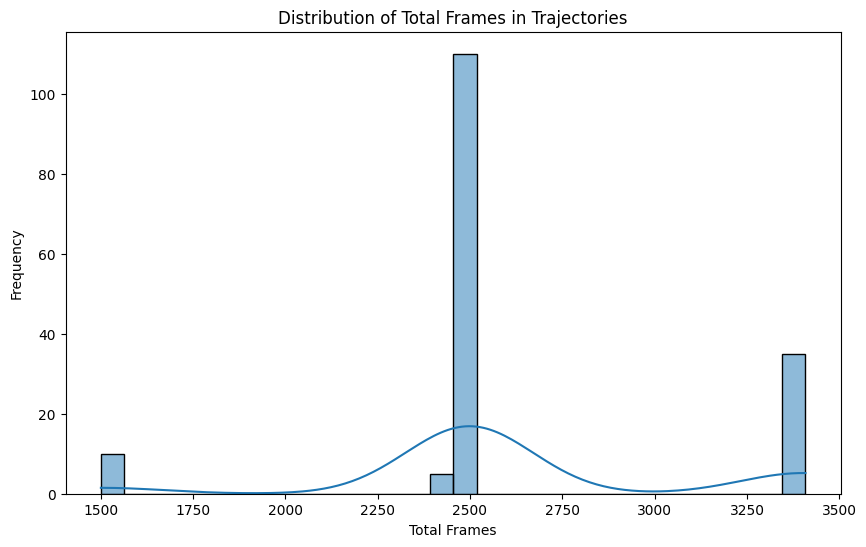

In [7]:
# Plot a distribution of the number of frames in trajectories
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(df_loaded['total_frames'], bins=30, kde=True)
plt.title('Distribution of Total Frames in Trajectories')
plt.xlabel('Total Frames')
plt.ylabel('Frequency')
plt.show()

In [8]:
# Divide the total number of frames in 4 clusters

import numpy as np
# Define the number of clusters
n_clusters = 4
# Assign cluster labels based on total frames
df_loaded['cluster'] = pd.cut(df_loaded['total_frames'], bins=n_clusters, labels=range(n_clusters))
display(df_loaded)

,directory,num_files,trajectory1,trajectory2,trajectory3,trajectory4,0,1,2,3,total_frames,cluster
0,/martini/rubiz/interaction_partner_paper/4_pai...,3,/martini/rubiz/interaction_partner_paper/4_pai...,/martini/rubiz/interaction_partner_paper/4_pai...,/martini/rubiz/interaction_partner_paper/4_pai...,NaN,1559,651,300,0,2510,2
1,/martini/rubiz/interaction_partner_paper/4_pai...,2,/martini/rubiz/interaction_partner_paper/4_pai...,/martini/rubiz/interaction_partner_paper/4_pai...,NaN,NaN,1593,911,0,0,2504,2
2,/martini/rubiz/interaction_partner_paper/4_pai...,2,/martini/rubiz/interaction_partner_paper/4_pai...,/martini/rubiz/interaction_partner_paper/4_pai...,NaN,NaN,1557,947,0,0,2504,2
3,/martini/rubiz/interaction_partner_paper/4_pai...,2,/martini/rubiz/interaction_partner_paper/4_pai...,/martini/rubiz/interaction_partner_paper/4_pai...,NaN,NaN,1534,970,0,0,2504,2
4,/martini/rubiz/interaction_partner_paper/4_pai...,2,/martini/rubiz/interaction_partner_paper/4_pai...,/martini/rubiz/interaction_partner_paper/4_pai...,NaN,NaN,1632,872,0,0,2504,2
...,...,...,...,...,...,...,...,...,...,...,...,...
155,/martini/rubiz/interaction_partner_paper/4_pai...,2,/martini/rubiz/interaction_partner_paper/4_pai...,/martini/rubiz/interaction_partner_paper/4_pai...,NaN,NaN,2013,488,0,0,2501,2
156,/martini/rubiz/interaction_partner_paper/4_pai...,2,/martini/rubiz/interaction_partner_paper/4_pai...,/martini/rubiz/interaction_partner_paper/4_pai...,NaN,NaN,1964,537,0,0,2501,2
157,/martini/rubiz/interaction_partner_paper/4_pai...,1,/martini/rubiz/interaction_partner_paper/4_pai...,NaN,NaN,NaN,1501,0,0,0,1501,0
158,/martini/rubiz/interaction_partner_paper/4_pai...,2,/martini/rubiz/interaction_partner_paper/4_pai...,/martini/rubiz/interaction_partner_paper/4_pai...,NaN,NaN,1700,801,0,0,2501,2


In [38]:
df_first_cluster = df_loaded[df_loaded['cluster'] == 0]
df_second_cluster = df_loaded[df_loaded['cluster'] == 1] # 2400 frames, 100 ns are missing, because the simulations were restarted before ending, non-critical 
df_third_cluster = df_loaded[df_loaded['cluster'] == 2] # 2500 frames, target
df_fourth_cluster = df_loaded[df_loaded['cluster'] == 3] 

In [10]:
display(df_second_cluster)

,directory,num_files,trajectory1,trajectory2,trajectory3,trajectory4,0,1,2,3,total_frames,cluster
97,/martini/rubiz/interaction_partner_paper/4_pai...,2,/martini/rubiz/interaction_partner_paper/4_pai...,/martini/rubiz/interaction_partner_paper/4_pai...,NaN,NaN,901,1501,0,0,2402,1
99,/martini/rubiz/interaction_partner_paper/4_pai...,2,/martini/rubiz/interaction_partner_paper/4_pai...,/martini/rubiz/interaction_partner_paper/4_pai...,NaN,NaN,901,1501,0,0,2402,1
101,/martini/rubiz/interaction_partner_paper/4_pai...,2,/martini/rubiz/interaction_partner_paper/4_pai...,/martini/rubiz/interaction_partner_paper/4_pai...,NaN,NaN,901,1501,0,0,2402,1
104,/martini/rubiz/interaction_partner_paper/4_pai...,2,/martini/rubiz/interaction_partner_paper/4_pai...,/martini/rubiz/interaction_partner_paper/4_pai...,NaN,NaN,901,1501,0,0,2402,1
107,/martini/rubiz/interaction_partner_paper/4_pai...,3,/martini/rubiz/interaction_partner_paper/4_pai...,/martini/rubiz/interaction_partner_paper/4_pai...,None,NaN,901,1501,0,0,2403,1


In [39]:
# Save directories with the first cluster
output_file_first_cluster = "/martini/rubiz/interaction_partner_paper/4_pairs/analysis/merge_trajectories_first_cluster.txt"
output_file_second_cluster = "/martini/rubiz/interaction_partner_paper/4_pairs/analysis/merge_trajectories_second_cluster.txt"
output_file_third_cluster = "/martini/rubiz/interaction_partner_paper/4_pairs/analysis/merge_trajectories_third_cluster.txt"
output_file_fourth_cluster = "/martini/rubiz/interaction_partner_paper/4_pairs/analysis/merge_trajectories_fourth_cluster.txt"
df_first_cluster['directory'].to_csv(output_file_first_cluster, index=False, header=False)
df_second_cluster['directory'].to_csv(output_file_second_cluster, index=False, header=False)
df_third_cluster['directory'].to_csv(output_file_third_cluster, index=False, header=False)
df_fourth_cluster['directory'].to_csv(output_file_fourth_cluster, index=False, header=False)

/martini/rubiz/thylakoid/scripts/nglview/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/martini/rubiz/thylakoid/scripts/nglview/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: D
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/martini/rubiz/thylakoid/scripts/nglview/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: G
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/martini/rubiz/thylakoid/scripts/nglview/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: R
  warnings.

/martini/rubiz/thylakoid/scripts/nglview/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/martini/rubiz/thylakoid/scripts/nglview/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: D
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/martini/rubiz/thylakoid/scripts/nglview/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: G
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/martini/rubiz/thylakoid/scripts/nglview/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: R
  warnings.

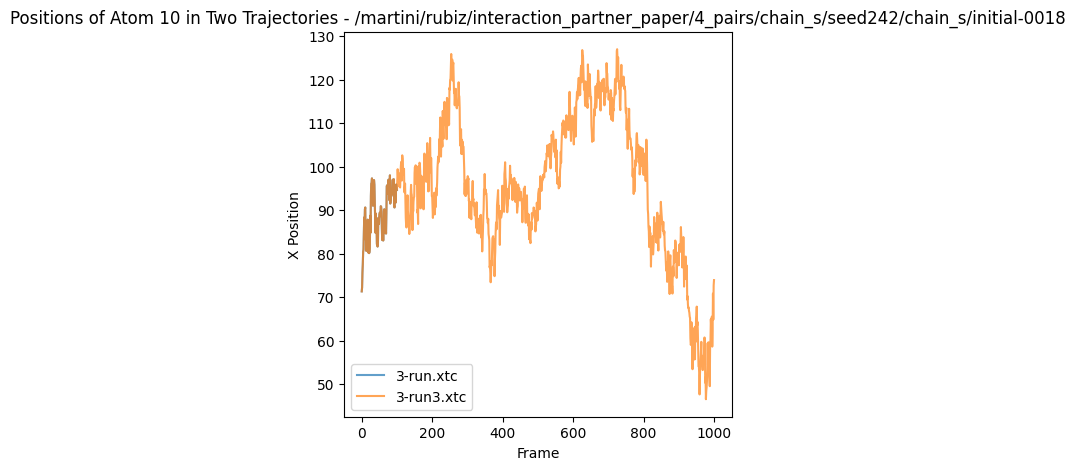

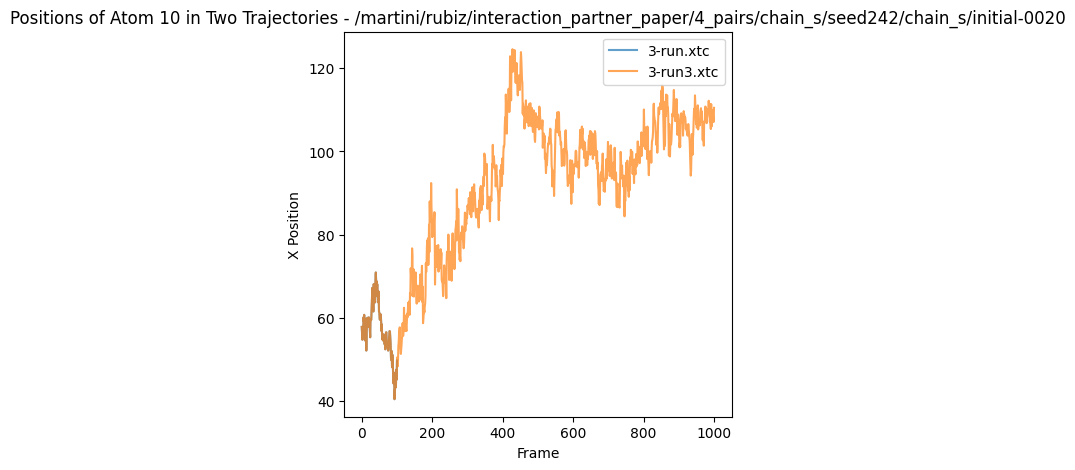

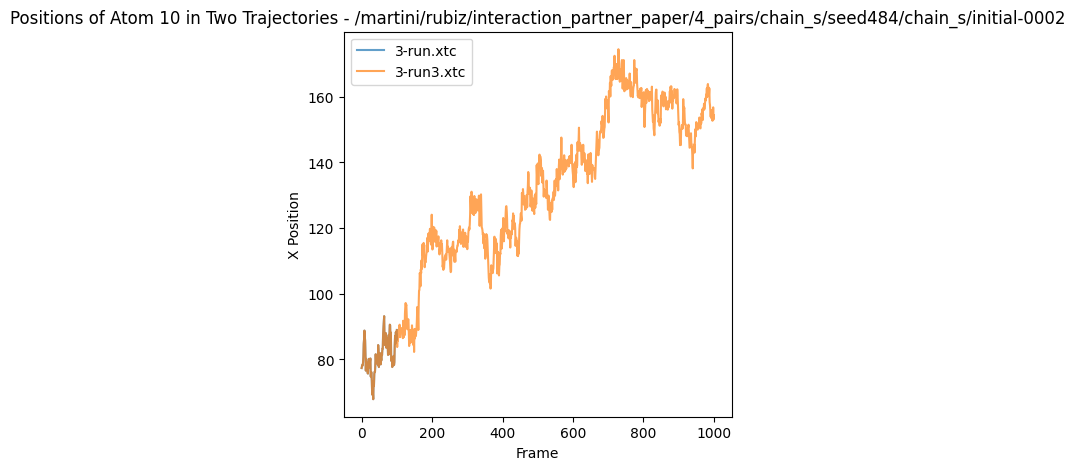

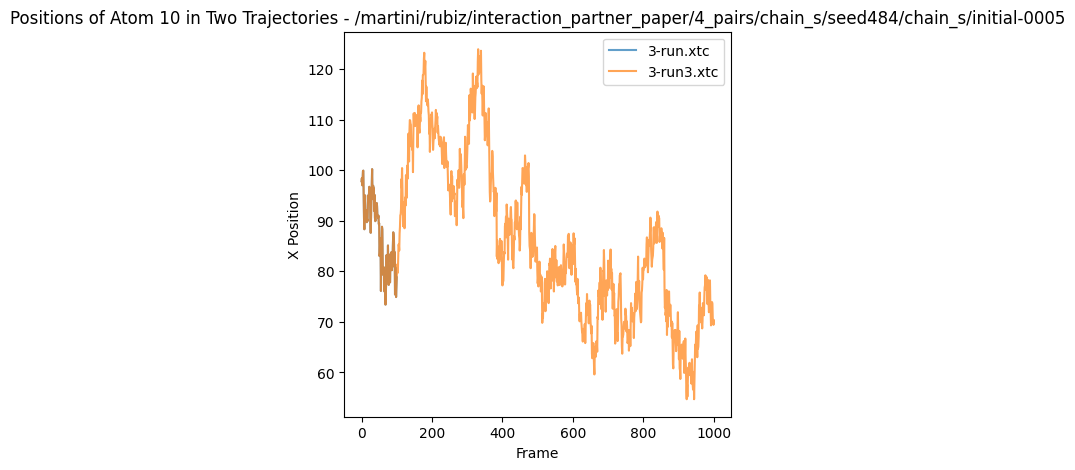

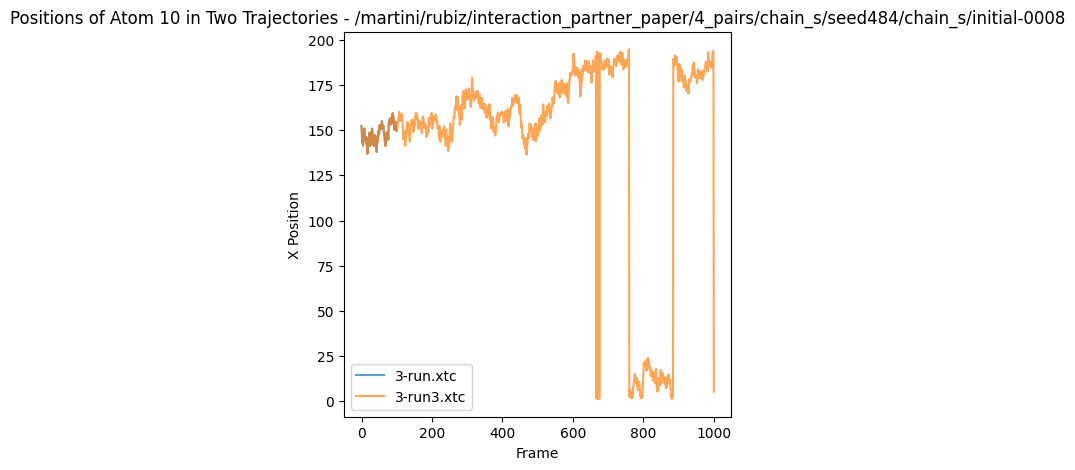

In [ ]:
u1_list = []
u2_list = []
for dir in df_third_cluster['directory']:
    # Load the universes for the two trajectories
    universe1 = mda.Universe(os.path.join(dir, 'ions.gro'), os.path.join(dir, '3-run.xtc'))
    universe2 = mda.Universe(os.path.join(dir, 'ions.gro'), os.path.join(dir, '3-run3.xtc'))
    
    u1_list.append(universe1)
    u2_list.append(universe2)

# Plot figure for each directory
for i, dir in enumerate(df_third_cluster['directory']):
    universe1 = u1_list[i]
    universe2 = u2_list[i]
    
    position1 = []
    position2 = []
    
    for ts1 in universe1.trajectory:
        #if ts1.frame % 10 == 0:
        position1.append(universe1.atoms[atom_index].position.copy())
    for ts2 in universe2.trajectory:
        position2.append(universe2.atoms[atom_index].position.copy())
    
    plt.figure(figsize=(5, 5))
    plt.plot([pos[0] for pos in position1], label='3-run.xtc', alpha=0.7)
    plt.plot([pos[0] for pos in position2], label='3-run3.xtc', alpha=0.7)
    plt.title(f'Positions of Atom {atom_index} in Two Trajectories - {dir}')
    plt.xlabel('Frame')
    plt.ylabel('X Position')
    plt.legend()
    plt.show()

### CONCLUSION CLUSTER ONE AND TWO:
The problem was that the first 200 ns were not concatenated from the trajectory 3-run.xtc, the problem was solved and now the trajectories have the 2500 frames

In [41]:
# Read again the number of frames in cluster one
dir1 = df_second_cluster['directory']

files = []
# Add 3-run3.xtc at the end of the array
for dir in dir1:
    files.append(os.path.join(dir, '3-run3.xtc'))






In [42]:
print(files)

['/martini/rubiz/interaction_partner_paper/4_pairs/chain_s/seed242/chain_s/initial-0018/3-run3.xtc', '/martini/rubiz/interaction_partner_paper/4_pairs/chain_s/seed242/chain_s/initial-0020/3-run3.xtc', '/martini/rubiz/interaction_partner_paper/4_pairs/chain_s/seed484/chain_s/initial-0002/3-run3.xtc', '/martini/rubiz/interaction_partner_paper/4_pairs/chain_s/seed484/chain_s/initial-0005/3-run3.xtc', '/martini/rubiz/interaction_partner_paper/4_pairs/chain_s/seed484/chain_s/initial-0008/3-run3.xtc']


In [43]:
results = gmx_check_parallel(files, n_jobs=16)

Step value: 1001
Step value: 1001
Step value: 1001
Step value: 1001
Step value: 1001


# Merging trajectories

In [5]:
file = 'merge_trajectories_results_updated.csv'
df = pd.read_csv(file)

In [ ]:
display(df)

In [6]:
# Add clustering results to the DataFrame
n_clusters = 2
df['cluster'] = pd.cut(df['total_frames'], bins=n_clusters, labels=range(n_clusters))

In [7]:
display(df)

,directory,num_files,trajectory1,trajectory2,trajectory3,trajectory4,0,1,2,3,cluster,total_frames
0,/martini/rubiz/interaction_partner_paper/4_pai...,3,/martini/rubiz/interaction_partner_paper/4_pai...,/martini/rubiz/interaction_partner_paper/4_pai...,/martini/rubiz/interaction_partner_paper/4_pai...,NaN,1559,651,300,0,1,2512
1,/martini/rubiz/interaction_partner_paper/4_pai...,2,/martini/rubiz/interaction_partner_paper/4_pai...,/martini/rubiz/interaction_partner_paper/4_pai...,NaN,NaN,1593,911,0,0,1,2506
2,/martini/rubiz/interaction_partner_paper/4_pai...,2,/martini/rubiz/interaction_partner_paper/4_pai...,/martini/rubiz/interaction_partner_paper/4_pai...,NaN,NaN,1557,947,0,0,1,2506
3,/martini/rubiz/interaction_partner_paper/4_pai...,2,/martini/rubiz/interaction_partner_paper/4_pai...,/martini/rubiz/interaction_partner_paper/4_pai...,NaN,NaN,1534,970,0,0,1,2506
4,/martini/rubiz/interaction_partner_paper/4_pai...,2,/martini/rubiz/interaction_partner_paper/4_pai...,/martini/rubiz/interaction_partner_paper/4_pai...,NaN,NaN,1632,872,0,0,1,2506
...,...,...,...,...,...,...,...,...,...,...,...,...
155,/martini/rubiz/interaction_partner_paper/4_pai...,2,/martini/rubiz/interaction_partner_paper/4_pai...,/martini/rubiz/interaction_partner_paper/4_pai...,NaN,NaN,2013,488,0,0,1,2503
156,/martini/rubiz/interaction_partner_paper/4_pai...,2,/martini/rubiz/interaction_partner_paper/4_pai...,/martini/rubiz/interaction_partner_paper/4_pai...,NaN,NaN,1964,537,0,0,1,2503
157,/martini/rubiz/interaction_partner_paper/4_pai...,1,/martini/rubiz/interaction_partner_paper/4_pai...,NaN,NaN,NaN,1501,0,0,0,0,1501
158,/martini/rubiz/interaction_partner_paper/4_pai...,2,/martini/rubiz/interaction_partner_paper/4_pai...,/martini/rubiz/interaction_partner_paper/4_pai...,NaN,NaN,1700,801,0,0,1,2503


In [8]:
df_cluster0 = df[df['cluster'] == 0]
df_cluster1 = df[df['cluster'] == 1]

In [10]:
display(df_cluster1)

,directory,num_files,trajectory1,trajectory2,trajectory3,trajectory4,0,1,2,3,cluster,total_frames
0,/martini/rubiz/interaction_partner_paper/4_pai...,3,/martini/rubiz/interaction_partner_paper/4_pai...,/martini/rubiz/interaction_partner_paper/4_pai...,/martini/rubiz/interaction_partner_paper/4_pai...,NaN,1559,651,300,0,1,2512
1,/martini/rubiz/interaction_partner_paper/4_pai...,2,/martini/rubiz/interaction_partner_paper/4_pai...,/martini/rubiz/interaction_partner_paper/4_pai...,NaN,NaN,1593,911,0,0,1,2506
2,/martini/rubiz/interaction_partner_paper/4_pai...,2,/martini/rubiz/interaction_partner_paper/4_pai...,/martini/rubiz/interaction_partner_paper/4_pai...,NaN,NaN,1557,947,0,0,1,2506
3,/martini/rubiz/interaction_partner_paper/4_pai...,2,/martini/rubiz/interaction_partner_paper/4_pai...,/martini/rubiz/interaction_partner_paper/4_pai...,NaN,NaN,1534,970,0,0,1,2506
4,/martini/rubiz/interaction_partner_paper/4_pai...,2,/martini/rubiz/interaction_partner_paper/4_pai...,/martini/rubiz/interaction_partner_paper/4_pai...,NaN,NaN,1632,872,0,0,1,2506
...,...,...,...,...,...,...,...,...,...,...,...,...
154,/martini/rubiz/interaction_partner_paper/4_pai...,2,/martini/rubiz/interaction_partner_paper/4_pai...,/martini/rubiz/interaction_partner_paper/4_pai...,NaN,NaN,1943,558,0,0,1,2503
155,/martini/rubiz/interaction_partner_paper/4_pai...,2,/martini/rubiz/interaction_partner_paper/4_pai...,/martini/rubiz/interaction_partner_paper/4_pai...,NaN,NaN,2013,488,0,0,1,2503
156,/martini/rubiz/interaction_partner_paper/4_pai...,2,/martini/rubiz/interaction_partner_paper/4_pai...,/martini/rubiz/interaction_partner_paper/4_pai...,NaN,NaN,1964,537,0,0,1,2503
158,/martini/rubiz/interaction_partner_paper/4_pai...,2,/martini/rubiz/interaction_partner_paper/4_pai...,/martini/rubiz/interaction_partner_paper/4_pai...,NaN,NaN,1700,801,0,0,1,2503


In [70]:
# Extract the trajactories as an array of arrays, drop the missing values
trajectories = df_cluster1.filter(like='trajectory').values.tolist()
trajectories = [[trj for trj in traj if trj] for traj in trajectories]

#Drop nan
try:
    trajectories = [[trj for trj in traj if not pd.isna(trj)] for traj in trajectories]
except Exception as e:
    print(f"Error while dropping NaN values: {e}")


In [ ]:
for array in trajectories:
    print(array)


In [50]:
output_file = "/martini/rubiz/interaction_partner_paper/4_pairs/analysis/merge_cluster1.sh"
with open(output_file, 'w') as f:
    for array in trajectories:
        # Concatenate the trajectories into one file
        command = gmx_concatenate(array, "all.xtc")
        #print(command)
        f.write(command + "\n")



In [ ]:
# Array with output files
output_files = []
for array in trajectories:
    basedir = os.path.dirname(array[0])  # Get the directory from the first trajectory
    output_file = f"{basedir}/all.xtc"
    output_files.append(output_file)
    print(output_file)

In [72]:
# Check the number of frames in the concatenated trajectory
results = gmx_check_parallel(output_files, n_jobs=10)
#print(trajectories[0])



Step value: 2501
Step value: 2501
Step value: 2501
Step value: 2501
Step value: 2501
Step value: 2501
Step value: 2501
Step value: 2501
Step value: 2501
Step value: 2501
Step value: 2501
Step value: 2501
Step value: 2501
Step value: 2501
Step value: 2501
Step value: 2473
Step value: 2501
Step value: 2501
Step value: 2501
Step value: 2501
Step value: 2501


In [73]:
print(results)

['2501', '2501', '2501', '2501', '2501', '2501', '2501', '2501', '2501', '2501', '2501', '2501', '2501', '2501', '2501', '2501', '2501', '2501', '2501', '2501', '2473', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


# Merge type 2 files

In [55]:
display(df_cluster0)

,directory,num_files,trajectory1,trajectory2,trajectory3,trajectory4,0,1,2,3,cluster,total_frames
51,/martini/rubiz/interaction_partner_paper/4_pai...,1,/martini/rubiz/interaction_partner_paper/4_pai...,NaN,NaN,NaN,1501,0,0,0,0,1501
58,/martini/rubiz/interaction_partner_paper/4_pai...,1,/martini/rubiz/interaction_partner_paper/4_pai...,NaN,NaN,NaN,1501,0,0,0,0,1501
60,/martini/rubiz/interaction_partner_paper/4_pai...,1,/martini/rubiz/interaction_partner_paper/4_pai...,NaN,NaN,NaN,1501,0,0,0,0,1501
69,/martini/rubiz/interaction_partner_paper/4_pai...,1,/martini/rubiz/interaction_partner_paper/4_pai...,NaN,NaN,NaN,1501,0,0,0,0,1501
72,/martini/rubiz/interaction_partner_paper/4_pai...,1,/martini/rubiz/interaction_partner_paper/4_pai...,NaN,NaN,NaN,1501,0,0,0,0,1501
73,/martini/rubiz/interaction_partner_paper/4_pai...,1,/martini/rubiz/interaction_partner_paper/4_pai...,NaN,NaN,NaN,1501,0,0,0,0,1501
76,/martini/rubiz/interaction_partner_paper/4_pai...,1,/martini/rubiz/interaction_partner_paper/4_pai...,NaN,NaN,NaN,1501,0,0,0,0,1501
97,/martini/rubiz/interaction_partner_paper/4_pai...,2,NaN,/martini/rubiz/interaction_partner_paper/4_pai...,NaN,NaN,0,1501,0,0,0,1502
99,/martini/rubiz/interaction_partner_paper/4_pai...,2,NaN,/martini/rubiz/interaction_partner_paper/4_pai...,NaN,NaN,0,1501,0,0,0,1502
101,/martini/rubiz/interaction_partner_paper/4_pai...,2,NaN,/martini/rubiz/interaction_partner_paper/4_pai...,NaN,NaN,0,1501,0,0,0,1502


In [60]:
# Check trajactories in cluster 0
flat_array = df_cluster0.filter(like='trajectory').values.flatten().tolist()
#Drop nan
flat_array = [trj for trj in flat_array if trj and not pd.isna(trj)]
print(flat_array)
gmx_check_parallel(flat_array, n_jobs=5)

['/martini/rubiz/interaction_partner_paper/4_pairs/chain_r/seed242/chain_r/initial-0012/3-run2.part0004.xtc', '/martini/rubiz/interaction_partner_paper/4_pairs/chain_r/seed242/chain_r/initial-0019/3-run2.part0004.xtc', '/martini/rubiz/interaction_partner_paper/4_pairs/chain_r/seed484/chain_r/initial-0001/3-run2.part0004.xtc', '/martini/rubiz/interaction_partner_paper/4_pairs/chain_r/seed484/chain_r/initial-0010/3-run2.part0004.xtc', '/martini/rubiz/interaction_partner_paper/4_pairs/chain_r/seed484/chain_r/initial-0013/3-run2.part0004.xtc', '/martini/rubiz/interaction_partner_paper/4_pairs/chain_r/seed484/chain_r/initial-0014/3-run2.part0004.xtc', '/martini/rubiz/interaction_partner_paper/4_pairs/chain_r/seed484/chain_r/initial-0017/3-run2.part0004.xtc', '/martini/rubiz/interaction_partner_paper/4_pairs/chain_s/seed242/chain_s/initial-0018/3-run2.part0004.xtc', '/martini/rubiz/interaction_partner_paper/4_pairs/chain_s/seed242/chain_s/initial-0020/3-run2.part0004.xtc', '/martini/rubiz/in

['1501',
 '1501',
 '1501',
 '1501',
 '1501',
 '1501',
 '1501',
 '1501',
 '1501',
 '1501',
 '1501',
 '1501',
 '1501',
 '1501',
 '1501']

In [67]:
# Extract the trajactories as an array of arrays, drop the missing values
trajectories = df_cluster0.filter(like='trajectory').values.tolist()
trajectories = [[trj for trj in traj if trj] for traj in trajectories]

#Drop nan
try:
    trajectories = [[trj for trj in traj if not pd.isna(trj)] for traj in trajectories]
except Exception as e:
    print(f"Error while dropping NaN values: {e}")

In [68]:
# Add the element "3-run3.xtc" to each array
for i in range(len(trajectories)):
    basedir = os.path.dirname(trajectories[i][0])  # Get the directory from the first trajectory
    trajectories[i].insert(0, f"{basedir}/3-run3.xtc")
    print(trajectories[i])

['/martini/rubiz/interaction_partner_paper/4_pairs/chain_r/seed242/chain_r/initial-0012/3-run3.xtc', '/martini/rubiz/interaction_partner_paper/4_pairs/chain_r/seed242/chain_r/initial-0012/3-run2.part0004.xtc']
['/martini/rubiz/interaction_partner_paper/4_pairs/chain_r/seed242/chain_r/initial-0019/3-run3.xtc', '/martini/rubiz/interaction_partner_paper/4_pairs/chain_r/seed242/chain_r/initial-0019/3-run2.part0004.xtc']
['/martini/rubiz/interaction_partner_paper/4_pairs/chain_r/seed484/chain_r/initial-0001/3-run3.xtc', '/martini/rubiz/interaction_partner_paper/4_pairs/chain_r/seed484/chain_r/initial-0001/3-run2.part0004.xtc']
['/martini/rubiz/interaction_partner_paper/4_pairs/chain_r/seed484/chain_r/initial-0010/3-run3.xtc', '/martini/rubiz/interaction_partner_paper/4_pairs/chain_r/seed484/chain_r/initial-0010/3-run2.part0004.xtc']
['/martini/rubiz/interaction_partner_paper/4_pairs/chain_r/seed484/chain_r/initial-0013/3-run3.xtc', '/martini/rubiz/interaction_partner_paper/4_pairs/chain_r/s

In [69]:
# Write the commands to a file
output_file = "/martini/rubiz/interaction_partner_paper/4_pairs/analysis/merge_cluster0.sh"
with open(output_file, 'w') as f:
    for array in trajectories:
        # Concatenate the trajectories into one file
        command = gmx_concatenate(array, "all.xtc")
        #print(command)
        f.write(command + "\n")